In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import cvxpy as cp
import os

In [2]:
def generate_evolution(logReturn, allocation, T_rebalancement=-1):
    nb_periods = logReturn.shape[0]
    nb_stocks = logReturn.shape[1]
    
    evolution = logReturn * 0.0
    
    if T_rebalancement == -1:
        # Buy and hold strategy
        evolution = np.exp(np.cumsum(logReturn)) * allocation
    else:
        # Rebalancing strategy
        evolution.iloc[:T_rebalancement, :] = np.exp(np.cumsum(logReturn.iloc[:T_rebalancement, :])) * allocation
        
        for i in range(T_rebalancement, nb_periods, T_rebalancement):
            evolution.iloc[i:i+T_rebalancement, :] = np.exp(np.cumsum(logReturn.iloc[i:i+T_rebalancement, :])) * evolution.iloc[i-1, :].sum() * allocation
        last_period = (nb_periods//T_rebalancement)*T_rebalancement
        evolution.iloc[last_period:, :] = np.exp(np.cumsum(logReturn.iloc[last_period:, :])) * evolution.iloc[last_period-1, :].sum() * allocation
    
    return evolution

Paramètres = {

    "Begin date" :
    "End date" :
    "Returns" :
    "Volatilities" :
    "Correlation matrix" :
    "Allocation" :
    "Rebalancing period" :
}

data_ESG : DataFrame

Contraints = {

    "lists" : ["Min return", "Esg Score min", "", ...]"
    "Value" : [ 0.05, ]
}

Contraints = {
    
    "lists" : ["sharpe", "Esg Score min", "", ...]"
    "Value" : [ 0, 0.05, 17, ]
}

In [3]:
class Simulation:
    def __init__(self, nb_scenarios, model, strategie, parametres, rf = 0.02):
        if not isinstance(nb_scenarios, int):
            raise ValueError("nb_scenarios must be an integer")
        if model not in ["BS", "On verra"]:
            raise ValueError("model must be either 'BS' or 'On verra'")
        if strategie not in ["Buy and hold", "Rebalancing"]:
            raise ValueError("strategie must be either 'Buy and hold' or 'Rebalancing")
        self.nb_scenarios = nb_scenarios
        self.model = model
        self.strategie = strategie
        self.parametres = parametres
        self.rf = rf
        #self.generate_scenarios()
        #self.generate_evolutions()

    def set_dataESG(self, dataESG):
        """""
        pandas.series representing the ESG data for each stock
        columns : 
            - Risque de durabilite
            - Risque exposition
            - Score de Management
            - Risque Carbone
            - Intensite carbonne (Tonnes de CO2)
        """
        self.dataESG = dataESG

    def set_contraints(self, contraints):
        """
        dictionnary representing the type and the value of contraints of the optimization problem

        {
            "List" : example ["Maximal volatilities" ou "Minimal return" ou "Sharpe" , "Minimal durability" ...]
            "Value : example [0, 0.1, ...]
        }
        """
        self.contraints = contraints

    def compute_allocation(self):
        """
        Calculate optimal portfolio allocation based on constraints and ESG data
        """
        # Define objective function based on criteria
        returns = self.parametres["Returns"]
        volatilities = self.parametres["Volatilities"]
        Correlation_matrix = self.parametres["Correlation matrix"]
        covMatrix = np.diag(volatilities) @ Correlation_matrix @ np.diag(volatilities)
        rf = self.rf
        dataESG = self.dataESG

        # Number of assets in portfolio
        nb_stocks = Correlation_matrix.shape[0]
        # Define portfolio weights as optimization variables
        w = cp.Variable(nb_stocks)
        # Define optimization Markowitz problem
        portfolio_return = cp.sum(w @ returns)
        portfolio_variance = cp.quad_form(w, covMatrix)
        constraints = [cp.sum(w) == 1, w >= 0]
        
        if "Maximal volatilities" in self.contraints["List"]:
            constraints.append(portfolio_variance <= self.contraints["Value"][self.contraints["List"].index("Maximal volatilities")])
            objective = cp.Maximize(portfolio_return)
        elif "Minimal return" in self.contraints["List"]:
            constraints.append(portfolio_return >= self.contraints["Value"][self.contraints["List"].index("Minimal return")])
            objective = cp.Minimize(portfolio_variance)
        elif "Sharpe" in self.contraints["List"]:
            objective = cp.Maximize((portfolio_return - rf) / cp.sqrt(portfolio_variance))
        else:
            objective = cp.Maximize(portfolio_return)

        # Define optimization ESG problem
        for i, criteria in enumerate(self.dataESG.columns):
            if "Maximal " + criteria in self.contraints["List"]:
                posCriteria = self.contraints["List"].index("Maximal " + criteria)
                constraints.append(cp.sum(w * dataESG[criteria]) <= self.contraints["Value"][posCriteria])
            elif "Minimal " + criteria in self.contraints["List"]:
                posCriteria = self.contraints["List"].index("Minimal " + criteria)
                constraints.append(cp.sum(w * dataESG[criteria]) >= self.contraints["Value"][posCriteria])

        # Define optimization problem
        prob = cp.Problem(objective, constraints)
        # Solve optimization problem
        prob.solve()
        # Get optimal portfolio weights
        self.allocation = w.value

    def generate_scenarios(self):
        nb_scenarios = self.nb_scenarios
        nb_stocks = len(self.parametres["Returns"])
        # Génération des dates excluant les samedis et dimanches
        dates = pd.date_range(start=self.parametres["Begin date"], end=self.parametres["End date"], freq='B')
        nb_periods = len(dates)
        # Calcul du facteur d'ajustement pour les volatilities
        delta_t = dates.to_series().diff().dt.days[1:] / 365.25
        delta_t = np.insert(delta_t, 0, 0)
        adjustment_factor = np.sqrt(delta_t)
        
        if self.model == "BS":
            volatilities = self.parametres["Volatilities"]
            returns = self.parametres["Returns"]
            # Génération de scénarios de log-rendements
            log_returns = np.random.normal(0, 1, (nb_periods, nb_stocks, nb_scenarios))
            cholesky_matrix = np.linalg.cholesky(self.parametres["Correlation matrix"])
            for i in range(self.nb_scenarios):
                log_returns[:, :, i] = log_returns[:, :, i] @ cholesky_matrix.T
            log_returns = log_returns * (volatilities.values[:, None] * adjustment_factor[:, None, None])
            # Ajout du rendement moyen annuel
            mean_returns = (returns.values[:, None] / 256.2305133079848) * delta_t[:, None, None]
            log_returns += mean_returns
            self.scenarios = {f'Scenario {i+1}': pd.DataFrame(log_returns[:, :, i], index=dates, columns=volatilities.index) for i in range(nb_scenarios)}

    def generate_evolutions(self):
        nb_periods = self.scenarios["Scenario 1"].shape[0]
        nb_stocks = self.scenarios["Scenario 1"].shape[0]
        T_rebalancement = self.parametres["Rebalancing period"] if self.strategie == "Rebalancing" else -1
        allocation = self.parametres["Allocation"]
        self.evolutions = {f'Evolution {i+1}' : generate_evolution(self.scenarios[f"Scenario {i+1}"], allocation, T_rebalancement) for i in range(self.nb_scenarios)}



In [4]:
if True :
    # Create dictionary to store dataFrames for the 40 CAC40 companies
    Data10y_dic = {}

    # Get list of files containing 'Data' in the "Data/CAC40 daily 10y"
    directory = "Data/CAC40 daily 10y"
    files = [f for f in os.listdir(directory) if 'Data' in f]
    # Process each file
    for file in files:
        # Get company name (first word before '_')
        company = file.split('_')[0]
        
        # Read the file with tab separator
        df = pd.read_csv(os.path.join(directory, file), sep='\t')
        
        # Convert first column to datetime and set as index
        df.index = pd.to_datetime(df['date'], format='%d/%m/%Y %H:%M')

        df = df.drop('date', axis=1)  # Remove the original date column
        df = df.dropna(axis=1, how='all') # Drop columns with all NaN values
        
        # Store in dictionary
        Data10y_dic[company] = df

    print(f"Loaded {len(Data10y_dic)} companies' data")

    # Create list of DataFrames with only 'clot' column
    dfs = [df['clot'] for df in Data10y_dic.values()]
    histo_CAC40 = pd.concat(dfs, axis=1, keys=Data10y_dic.keys())
    histo_CAC40 = histo_CAC40.sort_index()

    print(f"Shape of historical data: {histo_CAC40.shape}")
    print("\nFirst few rows:")
    # Drop rows with NaN values
    histo_CAC40_woNaN = histo_CAC40.dropna()
    print(f"Shape after dropping NaN rows: {histo_CAC40_woNaN.shape}")
    data = histo_CAC40_woNaN
    # Calcul du vecteur de rendement moyen annuel
    mu_annuel = np.log((data.iloc[-1, :]/data.iloc[0,:])) / (data.index[-1] - data.index[0]).days * 365.25
    delta_année = data.index.to_series().diff().dt.days.iloc[1:] / 365.25
    deltat_r = pd.DataFrame(delta_année.values[:, None] * mu_annuel.values, columns=mu_annuel.index, index=delta_année.index)
    nb_jour_pan = data.shape[0] / (data.index[-1] - data.index[0]).days * 365.25
    Volatilite_annuel = np.sqrt((np.log((data/data.shift(1)).iloc[1:,:]) - deltat_r).var() * nb_jour_pan)
    mat_correlation = (np.log((data/data.shift(1)).iloc[1:,:]) - deltat_r).corr()

    nb_stocks = 40
    allocations_EW = np.ones(nb_stocks) / nb_stocks

# Import the weights data of CAC40
CAC40_weights_df = pd.read_csv('Data/InfoCAC40.csv', sep=';').set_index('Societe')
# Convert string values to float
CAC40_weights = CAC40_weights_df.iloc[0, :].str.replace(',', '.').astype(float).values


Loaded 40 companies' data
Shape of historical data: (2562, 40)

First few rows:
Shape after dropping NaN rows: (1733, 40)


In [5]:
nb_simu = 2

parametres_BuyH = {
    "Begin date": '2025-03-10',
    "End date": '2035-03-10',
    "Returns": mu_annuel,
    "Volatilities": Volatilite_annuel,
    "Correlation matrix": mat_correlation,
    "Allocation": allocations_EW,
}
simulation_BuyH = Simulation(nb_scenarios=nb_simu, model="BS", strategie="Buy and hold", parametres=parametres_BuyH)
simulation_BuyH.generate_scenarios()
simulation_BuyH.generate_evolutions()

parametres_Rebal21 = {
    "Begin date": '2025-03-10',
    "End date": '2035-03-10',
    "Returns": mu_annuel,
    "Volatilities": Volatilite_annuel,
    "Correlation matrix": mat_correlation,
    "Allocation": allocations_EW,
    "Rebalancing period": 21
}
simulation_Rebal21 = Simulation(nb_scenarios=nb_simu, model="BS", strategie="Rebalancing", parametres=parametres_Rebal21)
simulation_Rebal21.scenarios = simulation_BuyH.scenarios
simulation_Rebal21.generate_evolutions()

parametres_Rebal5 = {
    "Begin date": '2025-03-10',
    "End date": '2035-03-10',
    "Returns": mu_annuel,
    "Volatilities": Volatilite_annuel,
    "Correlation matrix": mat_correlation,
    "Allocation": allocations_EW,
    "Rebalancing period": 5
}
simulation_Rebal5 = Simulation(nb_scenarios=nb_simu, model="BS", strategie="Rebalancing", parametres=parametres_Rebal5)
simulation_Rebal5.scenarios = simulation_BuyH.scenarios
simulation_Rebal5.generate_evolutions()

In [6]:
parametres_BuyH_sous_constrains = {
    "Begin date": '2025-03-10',
    "End date": '2035-03-10',
    "Returns": mu_annuel,
    "Volatilities": Volatilite_annuel,
    "Correlation matrix": mat_correlation
}
Data_esg = (pd.read_csv('Data/InfoCAC40.csv', sep=';').set_index('Societe').iloc[1:, :]).T
simulation_BuyH_sous_constrains = Simulation(nb_scenarios=10, model="BS", strategie="Buy and hold", parametres=parametres_BuyH_sous_constrains)
simulation_BuyH_sous_constrains.set_dataESG(Data_esg)
contraints = {
    "List" : ["Sharpe"],
    "Value" : [0]
}
simulation_BuyH_sous_constrains.set_contraints(contraints)
simulation_BuyH_sous_constrains.compute_allocation()


DCPError: Problem does not follow DCP rules. Specifically:
The objective is not DCP. Its following subexpressions are not:
power(QuadForm(var1, [[0.12 0.09 ... 0.05 0.06]
 [0.09 0.15 ... 0.05 0.07]
 ...
 [0.05 0.05 ... 0.07 0.05]
 [0.06 0.07 ... 0.05 0.08]]), 0.5)

In [ ]:
corr = simulation_BuyH_sous_constrains.parametres["Correlation matrix"]
vol = simulation_BuyH_sous_constrains.parametres["Volatilities"]
vol.shape
# Matrix de correlation

(40,)

In [ ]:
# Calcul de la matrice de covariance
covMatrix = np.diag(vol) @ mat_correlation @ np.diag(vol)
print(covMatrix)

          0         1         2         3         4         5         6   \
0   0.115464  0.086221  0.027073  0.076375  0.051255  0.068934  0.054005   
1   0.086221  0.147293  0.035211  0.090163  0.057631  0.076619  0.063651   
2   0.027073  0.035211  0.042183  0.040233  0.028058  0.031360  0.028047   
3   0.076375  0.090163  0.040233  0.193682  0.067014  0.090496  0.066791   
4   0.051255  0.057631  0.028058  0.067014  0.067005  0.063305  0.044945   
5   0.068934  0.076619  0.031360  0.090496  0.063305  0.110431  0.057786   
6   0.054005  0.063651  0.028047  0.066791  0.044945  0.057786  0.078898   
7   0.034966  0.042089  0.025088  0.043129  0.029404  0.036620  0.030812   
8   0.046496  0.055350  0.030198  0.060010  0.039106  0.045125  0.037097   
9   0.023126  0.022316  0.017262  0.032907  0.023329  0.028891  0.025056   
10  0.064252  0.069687  0.029530  0.087292  0.059492  0.089069  0.056598   
11  0.019441  0.023513  0.017422  0.018254  0.018245  0.021000  0.018806   
12  0.027597

In [ ]:
# Import the weights data of CAC40
CAC40_weights_df = pd.read_csv('Data/InfoCAC40.csv', sep=';').set_index('Societe')
# Convert string values to float
CAC40_weights = CAC40_weights_df.iloc[0, :].str.replace(',', '.').astype(float).values

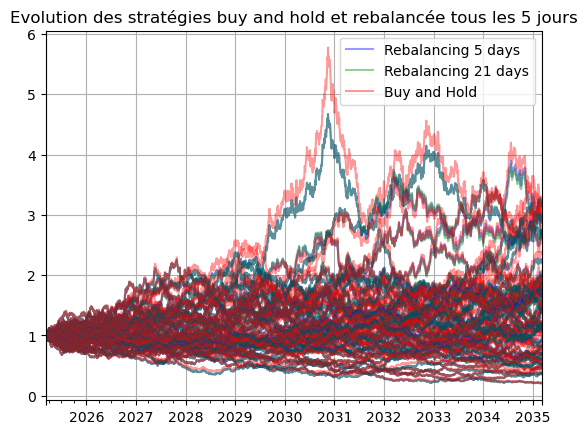

In [ ]:
lines = []
evolution_rebal5 = simulation_Rebal5.evolutions
evolution_BuyH = simulation_BuyH.evolutions
evolution_rebal21 = simulation_Rebal21.evolutions

for evolution_name, evolution_data in evolution_rebal5.items():
    lines.append(evolution_data.sum(axis=1).plot(color="blue", alpha=0.4, label="Rebalancing 5 days"))
    lines.append(evolution_rebal21[evolution_name].sum(axis=1).plot(color="green", alpha=0.4, label="Rebalancing 21 days"))
    lines.append(evolution_BuyH[evolution_name].sum(axis=1).plot(color="red", alpha=0.4, label="Buy and Hold"))

plt.title("Evolution des stratégies buy and hold et rebalancée tous les 5 jours")
plt.grid()

# Get unique legend handles and labels
handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys())

plt.show()



In [ ]:
def optimalAllocation_sharpe_minVol(returns, covMatrix, criteria='sharpe', rf=0.0):
    """
    Calculate optimal portfolio allocation based on either Sharpe ratio maximization or minimum volatility.
    
    Parameters:
    -----------
    returns : pandas.Series
        Expected returns for each asset
    covMatrix : pandas.DataFrame
        Variance-covariance matrix of asset returns
    criteria : str, optional (default='sharpe')
        Optimization criteria: 'sharpe' for maximum Sharpe ratio or 'min_volatility' for minimum volatility
    rf : float, optional (default=0.0)
        Risk-free rate used in Sharpe ratio calculation
        
    Returns:
    --------
    numpy.ndarray
        Optimal portfolio weights for each asset
        
    Notes:
    ------
    - For 'sharpe' criteria: maximizes (portfolio_return - rf) / portfolio_volatility
    - For 'min_volatility' criteria: minimizes portfolio_volatility
    - Constraints: weights sum to 1 and no short-selling (weights >= 0)
    """
    # Number of assets in portfolio
    nb_stocks = covMatrix.shape[0]
    # Define portfolio weights as optimization variables
    w = cp.Variable(nb_stocks)
    # Define objective function based on criteria
    if criteria == 'sharpe':
        portfolio_return = returns @ w
        portfolio_variance = cp.quad_form(w, covMatrix)
        objective = cp.Maximize((portfolio_return - rf) / cp.sqrt(portfolio_variance))
    elif criteria == 'min_volatility':
        portfolio_variance = cp.quad_form(w, covMatrix)
        objective = cp.Minimize(cp.sqrt(portfolio_variance))
    else:
        raise ValueError("Invalid criteria. Use 'sharpe' or 'min_volatility'.")

    # Define constraints: weights sum to 1 and no short-selling
    constraints = [cp.sum(w) == 1, w >= 0]
    # Solve optimization problem
    problem = cp.Problem(objective, constraints)
    problem.solve()

    return w.value

def optimalAllocation_limitVol(returns, covMatrix, limitMaxVol, rf=0.0):
    """
    Calculate optimal portfolio allocation with volatility constraint.
    
    Parameters:
    -----------
    returns : pandas.Series
        Expected returns for each asset
    covMatrix : pandas.DataFrame
        Variance-covariance matrix of asset returns
    limitMaxVol : float
        Maximum allowed portfolio volatility
    rf : float, optional (default=0.0)
        Risk-free rate used in Sharpe ratio calculation
        
    Returns:
    --------
    numpy.ndarray
        Optimal portfolio weights for each asset
    """
    # Number of assets in portfolio
    nb_stocks = covMatrix.shape[0]
    
    # Define portfolio weights as optimization variables
    w = cp.Variable(nb_stocks)
    
    # Portfolio return and variance
    portfolio_return = returns @ w
    portfolio_variance = cp.quad_form(w, covMatrix)
    
    # Define objective function: maximize Sharpe ratio
    objective = cp.Maximize(portfolio_return)
    
    # Define constraints:
    constraints = [
        cp.sum(w) == 1,
        w >= 0,
        cp.sqrt(portfolio_variance) <= limitMaxVol
    ]
    
    # Solve optimization problem
    problem = cp.Problem(objective, constraints)
    problem.solve()
    
    return w.value

def optimalAllocation_limitRet(returns, covMatrix, limitMinRet, rf=0.0):
    """
    Calculate optimal portfolio allocation with return constraint.
    
    Parameters:
    -----------
    returns : pandas.Series
        Expected returns for each asset
    covMatrix : pandas.DataFrame
        Variance-covariance matrix of asset returns
    limitMinRet : float
        Minimum required portfolio return
    rf : float, optional (default=0.0)
        Risk-free rate used in Sharpe ratio calculation
        
    Returns:
    --------
    numpy.ndarray
        Optimal portfolio weights for each asset
    """
    # Number of assets in portfolio
    nb_stocks = covMatrix.shape[0]
    
    # Define portfolio weights as optimization variables
    w = cp.Variable(nb_stocks)
    
    # Portfolio return and variance
    portfolio_return = returns @ w
    portfolio_variance = cp.quad_form(w, covMatrix)
    
    # Define objective function: minimise volatility
    objective = cp.Minimize(portfolio_variance)
    
    # Define constraints:
    constraints = [
        cp.sum(w) == 1,
        w >= 0,
        portfolio_return >= limitMinRet
    ]
    
    # Solve optimization problem
    problem = cp.Problem(objective, constraints)
    problem.solve()
    
    return w.value
